---
---
# NEURAL STYLE TRANSFER
---
---

# STEP 1 - Generating The Content
* E.g. given an image, can we recrate the same image

In [9]:
#from __future__ import print_function, division
#from builtins import range, input
#
#import tensorflow as tf
#
#from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
##from keras.layers.convolutional import Conv2D
#from tensorflow.keras.models import Model, Sequential
#from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
#from tensorflow.keras.preprocessing import image
#import tensorflow.keras.backend as K #we can't use fit function, we need this to reach gradients to use gradient descent or another loss
#import matplotlib.pyplot as plt 
#import numpy as np
#from scipy.optimize import fmin_l_bfgs_b #key algorithm
#
#from __future__ import print_function, division
#from builtins import range, input
#
#
#from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
##from keras.layers.convolutional import Conv2D
#from keras.models import Model, Sequential
#from keras.applications.vgg16 import VGG16, preprocess_input
#from keras.preprocessing import image
#import keras.backend as K #we can't use fit function, we need this to reach gradients to use gradient descent or another loss
#import matplotlib.pyplot as plt 
#import numpy as np
#from scipy.optimize import fmin_l_bfgs_b #key algorithm

In [10]:
from __future__ import print_function, division
from builtins import range, input

import tensorflow as tf

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt 
import numpy as np
from scipy.optimize import fmin_l_bfgs_b

In [11]:
def VGG16_AvgPool(shape):
    #we want to account for features across the entire image
    #so we get rid of the maxpool which throws away information
    #NOT: we still lose some information but as much as maxpooling
    vgg = VGG16(input_shape=shape,
                weights='imagenet',
                include_top=False)
    #Functional API
    input_ = vgg.input
    x = input_ # start from input
    # first layer is input, therefore start from 2nd index
    for layer in vgg.layers[1:]:
        if isinstance(layer, MaxPooling2D):
            #replace it with average pooling
            x = AveragePooling2D(pool_size=(2, 2), 
                                 strides=(2, 2), 
                                 padding='valid')(x)
        else:
            x = layer(x)
    # we have a graph network now. -> .input and .output can be use
    model = Model(inputs=input_, outputs=x, name="vgg16_avgpool")
    return model

In [12]:
def VGG16_AvgPool_CutOff(shape, num_convs):
    # there are 13 convolutions in vgg16 total
    # we can pick any of them as the "output"
    # of our content model
    if num_convs < 1 or num_convs > 13:
        print("num_convs must be in the range [1,13]")
        return None
    #create average pooling vgg
    base_model = VGG16_AvgPool(shape)

    # count conv2d
    conv_count = 0
    cutoff_layer = None

    for layer in base_model.layers:
        if isinstance(layer, Conv2D):
            conv_count+=1
            if conv_count == num_convs:
                cutoff_layer = layer
                break
    if cutoff_layer is None:
        raise ValueError("Could not find the requested Conv2D layer.")

    cut_model = Model(inputs=base_model.input,
                      outputs=cutoff_layer.output,
                      name=f"vgg16_avgpool_cutoff_{num_convs}")    
    return cut_model

In [13]:
# vgg expects caffe format. In coffe format, 
# RGB is converted to BGR and the channel average 
# used in ImageNet training is extracted from each channel.
def unpreprocess(img):
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    return img

# It performs min-max normalization by setting 
# the minimum of the image (or a gradient map) 
# to 0 and the maximum to 1.
# This is especially useful when 
# visualizing gradients or feature maps; 
# regardless of the value range, 
# the image is normalized and becomes visible on the screen.
def scale_img(x):
    x = x - x.min()
    x = x / x.max()
    return x

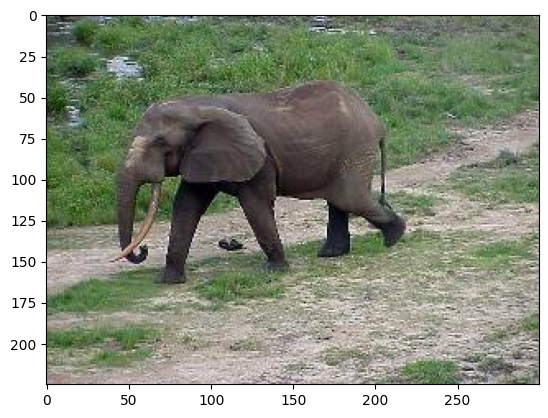

In [14]:
#load an img
path = '/kaggle/input/dataset/Data/elephant.jpg'
img = image.load_img(path)

#convert img to array and preprocess for vgg
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

#we will use this throuht the rest of the script
batch_shape = x.shape # hxwxc     #c: colour
shape = x.shape[1:]   # 1xhxwxc

#see the image
plt.imshow(img)
plt.show()

In [15]:
# -----------------------------
# Content model & target
# -----------------------------

#select a cutoff to see the image that result
content_model = VGG16_AvgPool_CutOff(shape=shape, 
                                     num_convs=11)
# make the target
target = content_model(x) # shape: (1, h, w, c)
target = tf.stop_gradient(target) # keep it steady during optimization

# -----------------------------
# Loss + Gradient fonksiyonu
# -----------------------------
batch_shape = x.shape  # (1, H, W, 3)

def loss_and_grads(x_flat):
    """
    x_flat: flattened image (numpy 1D)
    return: (loss_value, grads_flat)
    """
    # 1) Change x_flat back to (1, H, W, 3)
    x_in = tf.reshape(x_flat, batch_shape)
    with tf.GradientTape() as tape:
        tape.watch(x_in)
        feats = content_model(x_in)
        #we are using all TF ops here, no KerasTensor
        loss_value = tf.reduce_mean(tf.square(feats - target))
    grads = tape.gradient(loss_value, x_in)
    # For SciPy, return numpy float and flattened grad
    loss_value = loss_value.numpy().astype('float64')
    grads = grads.numpy().flatten().astype('float64')
    return loss_value, grads

min: -127.0  max: 127.0
iter=0, loss=919.0765380859375
min: -127.0  max: 127.0
iter=1, loss=345.9051818847656
min: -127.0  max: 127.0
iter=2, loss=204.8898162841797
min: -127.0  max: 127.0
iter=3, loss=143.21603393554688
min: -127.0  max: 127.0
iter=4, loss=108.02086639404297
min: -127.0  max: 127.0
iter=5, loss=88.58473205566406
min: -127.0  max: 127.0
iter=6, loss=76.30474853515625
min: -127.0  max: 127.0
iter=7, loss=66.27030181884766
min: -127.0  max: 127.0
iter=8, loss=59.48164749145508
min: -127.0  max: 127.0
iter=9, loss=54.65794372558594
min: -127.0  max: 127.0
iter=10, loss=49.74443817138672
min: -127.0  max: 127.0
iter=11, loss=46.14002990722656
min: -127.0  max: 127.0
iter=12, loss=42.98373794555664
min: -127.0  max: 127.0
iter=13, loss=40.54121017456055
min: -127.0  max: 127.0
iter=14, loss=38.28044509887695
min: -127.0  max: 127.0
iter=15, loss=36.1446647644043
min: -127.0  max: 127.0
iter=16, loss=34.48000717163086
min: -127.0  max: 127.0
iter=17, loss=32.9694938659668
mi

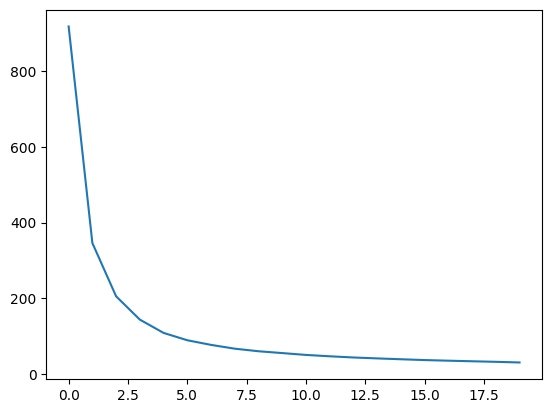

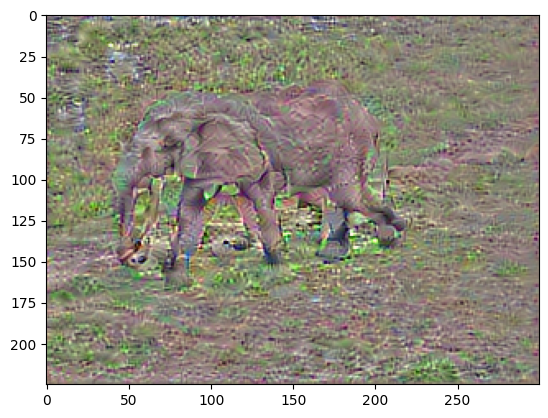

In [24]:
from datetime import datetime
t0=datetime.now()
losses = []
x = np.random.randn(np.prod(batch_shape))
#x = x.flatten().astype('float64')
for i in range(20):
    x, l, _ = fmin_l_bfgs_b(func=loss_and_grads,
                            x0=x,
                            #bounds=[[-127,127]* len(x.flatten())]
                            maxfun =20) 
    x = np.clip(x,-127, 127)
    print("min:", x.min(), " max:", x.max())
    print("iter=%s, loss=%s" % ((i,l)))
    losses.append(l)

print("duration:", datetime.now() - t0)
plt.plot(losses)
plt.show()

new_img = x.reshape(*batch_shape)
final_img=unpreprocess(new_img)

plt.imshow(scale_img(final_img[0]))
plt.show()

iter=0, loss=103.12349700927734, min=-46.99619690804289, max=127.0


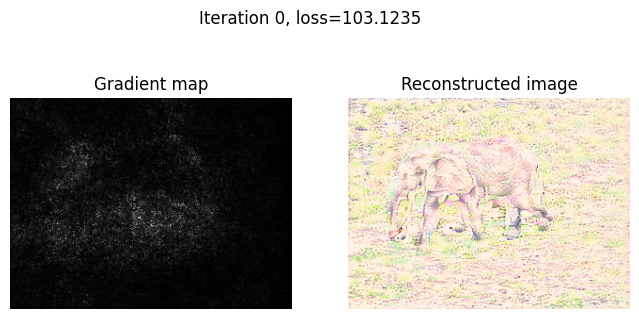

iter=1, loss=130.09071350097656, min=-66.26672620433672, max=127.0


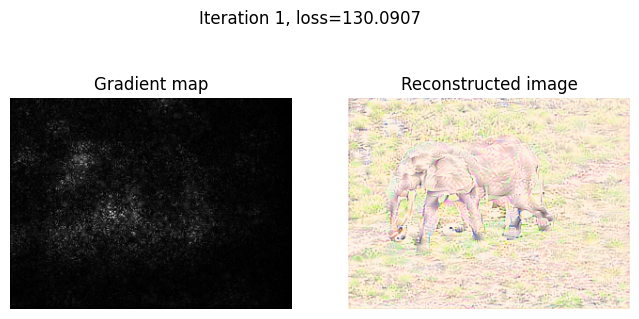

iter=2, loss=92.91879272460938, min=-79.40391570657012, max=127.0


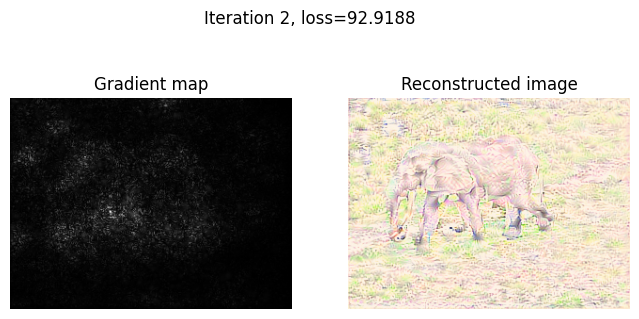

iter=3, loss=72.66899108886719, min=-86.08165842283293, max=127.0


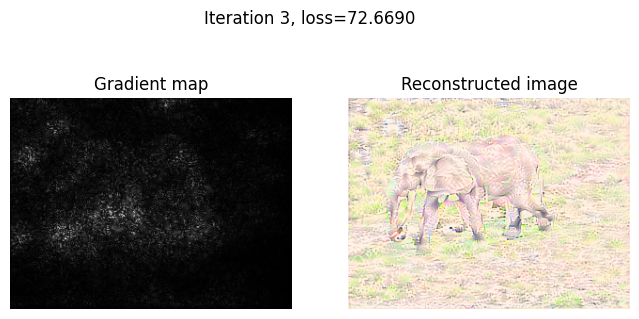

iter=4, loss=61.30324935913086, min=-93.04480274948574, max=127.0


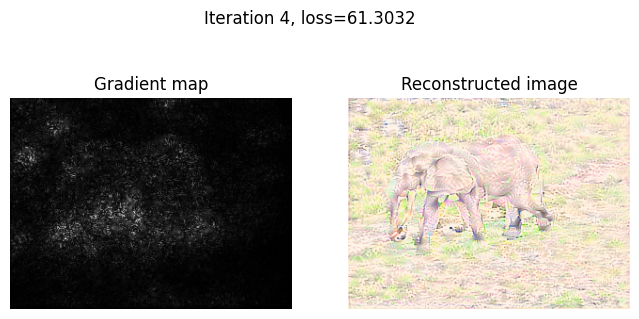

iter=5, loss=56.39894104003906, min=-98.4402979079137, max=127.0


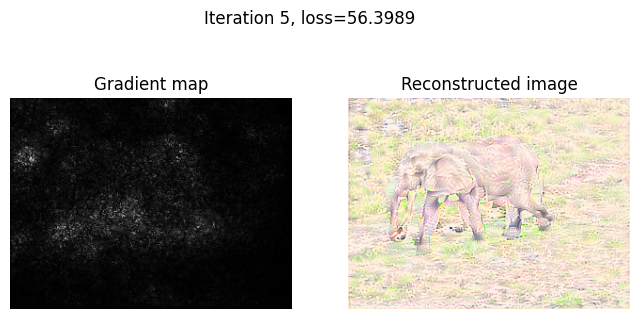

iter=6, loss=49.879005432128906, min=-105.13719900178954, max=127.0


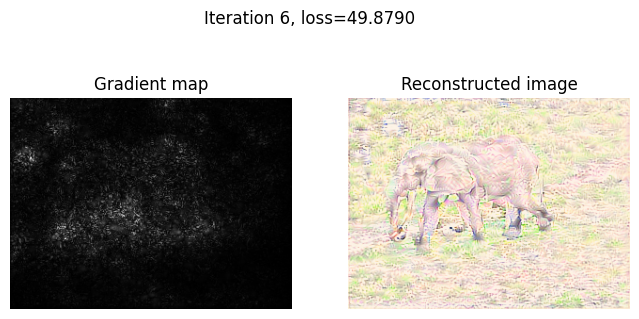

iter=7, loss=46.706783294677734, min=-108.99402124301335, max=127.0


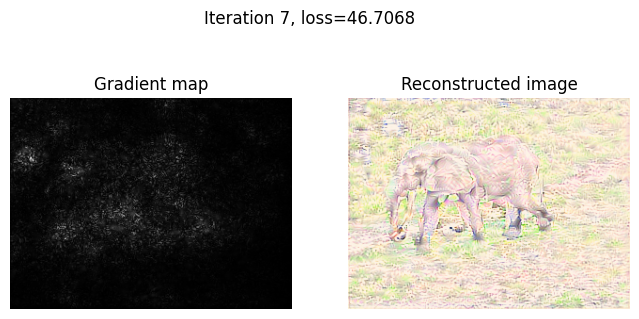

iter=8, loss=42.492774963378906, min=-113.11185372488075, max=127.0


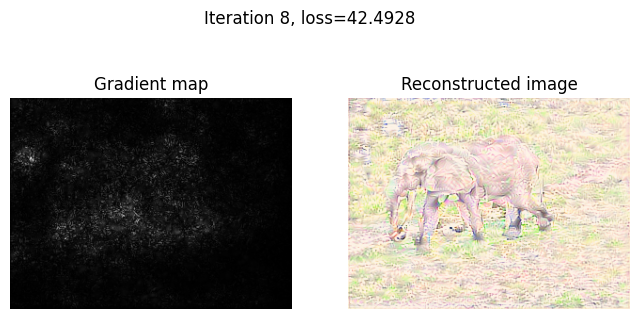

iter=9, loss=40.24896240234375, min=-115.48234414267044, max=127.0


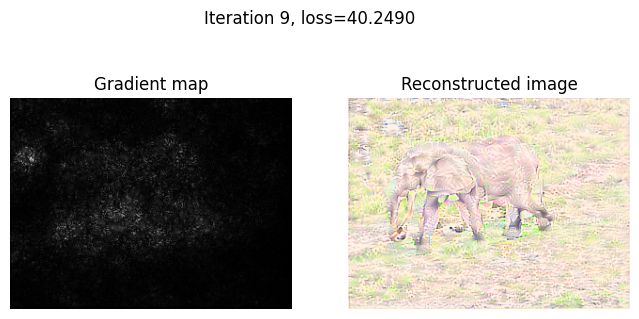

duration: 0:00:18.032714


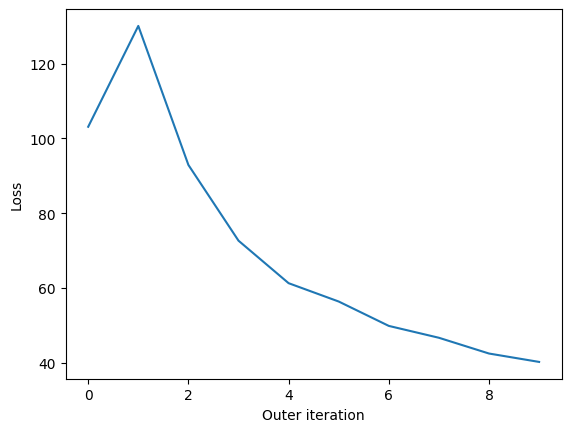

iter=0, loss=920.4580078125, min=-127.0, max=127.0


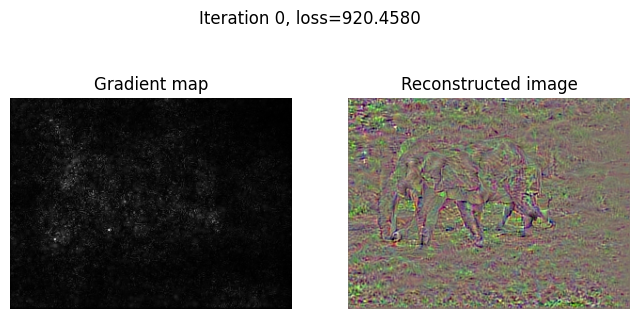

iter=1, loss=343.9246520996094, min=-127.0, max=127.0


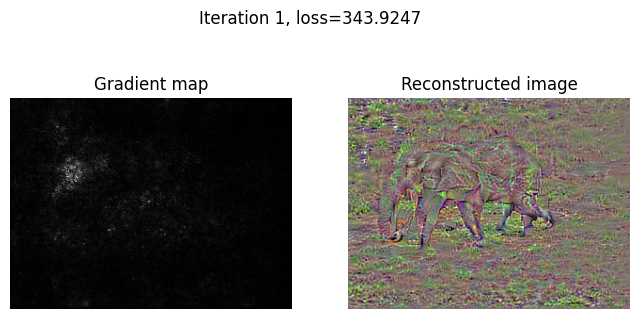

iter=2, loss=211.99232482910156, min=-127.0, max=127.0


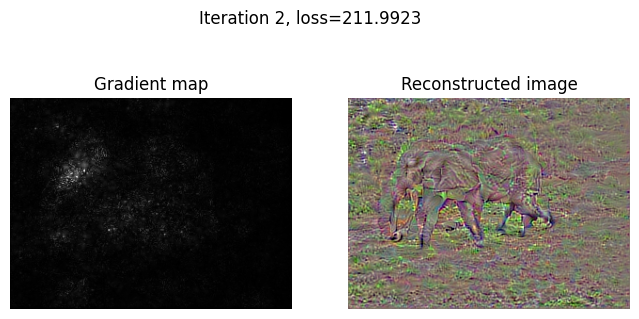

iter=3, loss=152.85047912597656, min=-127.0, max=127.0


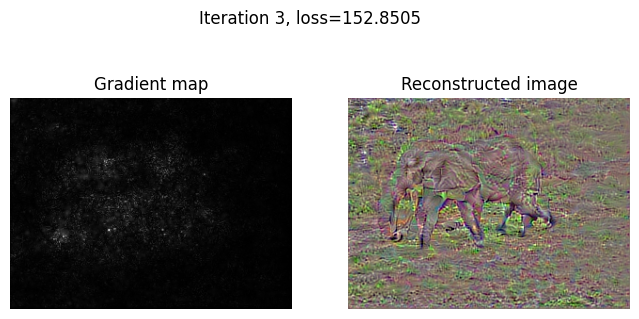

iter=4, loss=121.7204360961914, min=-127.0, max=127.0


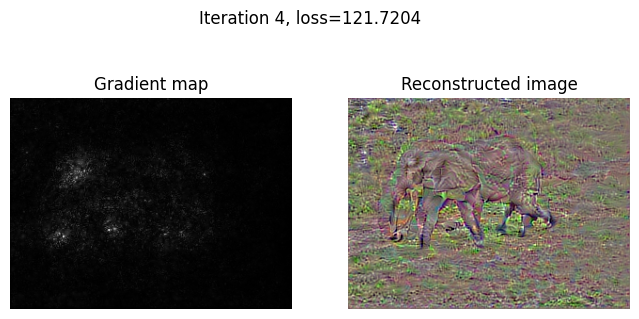

iter=5, loss=100.4826889038086, min=-127.0, max=127.0


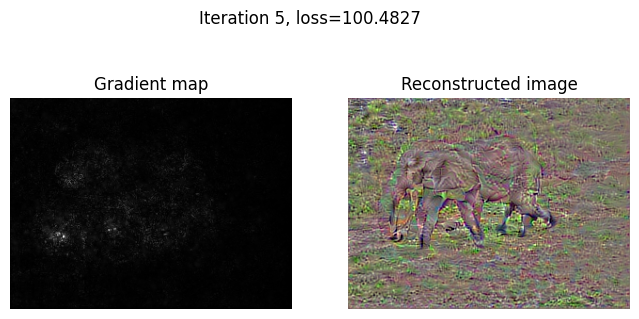

iter=6, loss=87.73150634765625, min=-127.0, max=127.0


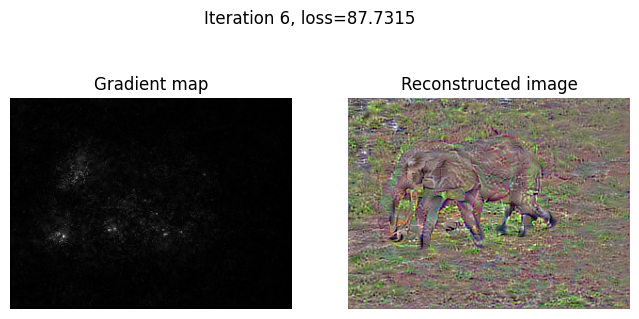

iter=7, loss=77.40899658203125, min=-127.0, max=127.0


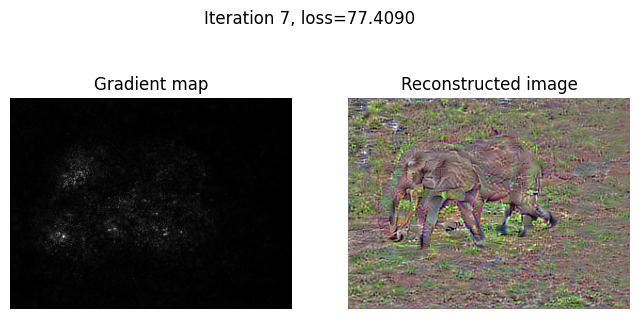

iter=8, loss=69.986328125, min=-127.0, max=127.0


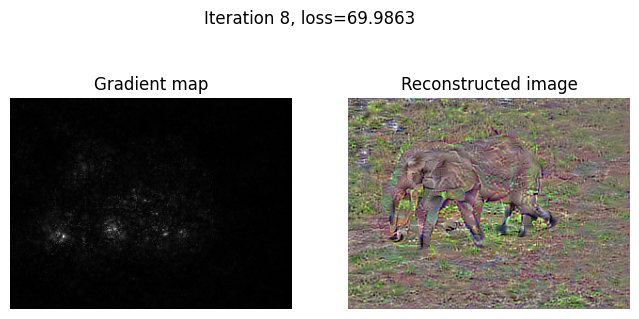

iter=9, loss=64.96281433105469, min=-127.0, max=127.0


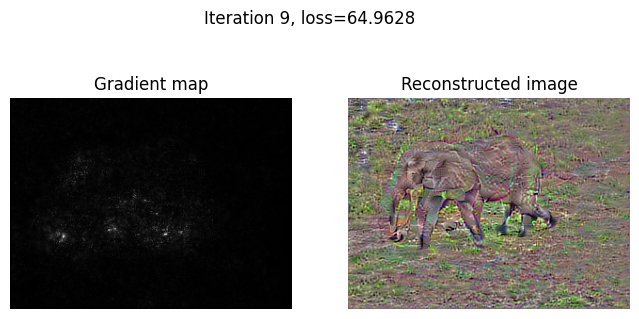

duration: 0:00:18.149256


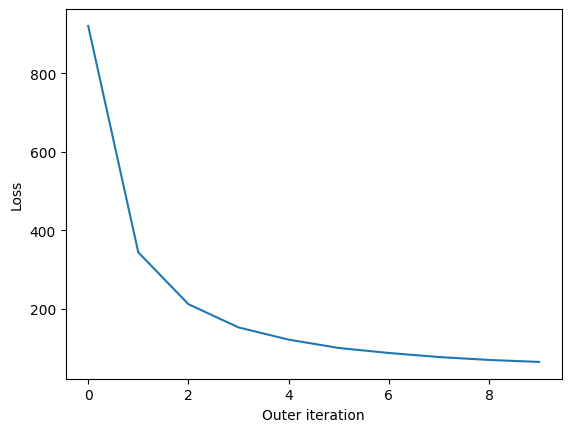

In [25]:
#advaced function
from datetime import datetime

def run_lbfgs_with_vis(use_random_init=False,
                       outer_iters=10,
                       maxfun=20):
    """
    use_random_init = False -> x (content image) ile başlar
    use_random_init = True  -> random gürültü ile başlar
    """
    global x, batch_shape  # x: preprocess_input sonrası içerik resmi

    # --- başlangıç vektörü ---
    if use_random_init:
        x_vec = np.random.randn(np.prod(batch_shape)).astype("float64")
    else:
        x_vec = x.flatten().astype("float64")

    t0 = datetime.now()
    losses = []

    for i in range(outer_iters):
        # L-BFGS adımı
        x_vec, l, _ = fmin_l_bfgs_b(
            func=loss_and_grads,
            x0=x_vec,
            maxfun=maxfun
        )
        x_vec = np.clip(x_vec, -127, 127)

        print(f"iter={i}, loss={l}, min={x_vec.min()}, max={x_vec.max()}")
        losses.append(l)

        # ---- Görselleştirme: gradient + image ----
        # Gradient map için mevcut x_vec ile loss_and_grads çağır
        _, grads_flat = loss_and_grads(x_vec)
        grad_img = grads_flat.reshape(batch_shape)   # (1, H, W, 3)

        # Channel ortalamasını alıp normalize edelim (gradient map)
        grad_mag = np.mean(np.abs(grad_img[0]), axis=-1)  # (H, W)
        grad_vis = scale_img(grad_mag)

        # Görüntü
        img_cur = x_vec.reshape(batch_shape)
        img_cur = unpreprocess(img_cur.copy())
        img_vis = np.clip(img_cur[0], 0, 255).astype("uint8")

        plt.figure(figsize=(8, 4))
        plt.suptitle(f"Iteration {i}, loss={l:.4f}")

        plt.subplot(1, 2, 1)
        plt.title("Gradient map")
        plt.imshow(grad_vis, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Reconstructed image")
        plt.imshow(img_vis)
        plt.axis("off")

        plt.show()
        # -----------------------------------------

    print("duration:", datetime.now() - t0)

    # Loss grafiği
    plt.figure()
    plt.plot(losses)
    plt.xlabel("Outer iteration")
    plt.ylabel("Loss")
    plt.show()

    # Final image return
    final_img = x_vec.reshape(batch_shape)
    final_img = unpreprocess(final_img.copy())
    return final_img

# İçerik resminden başla:
final_from_content = run_lbfgs_with_vis(use_random_init=False)

# Random gürültüden başla:
final_from_noise = run_lbfgs_with_vis(use_random_init=True)
